# **Landing a spacecraft using PINNs**

---
---

This code will contain an attempt to simulate the landing of a spacecraft as controlled by a Physics Informed neural network as described in the following [paper](https://www.nature.com/articles/s41598-023-49977-3.pdf). 

#### Physical description

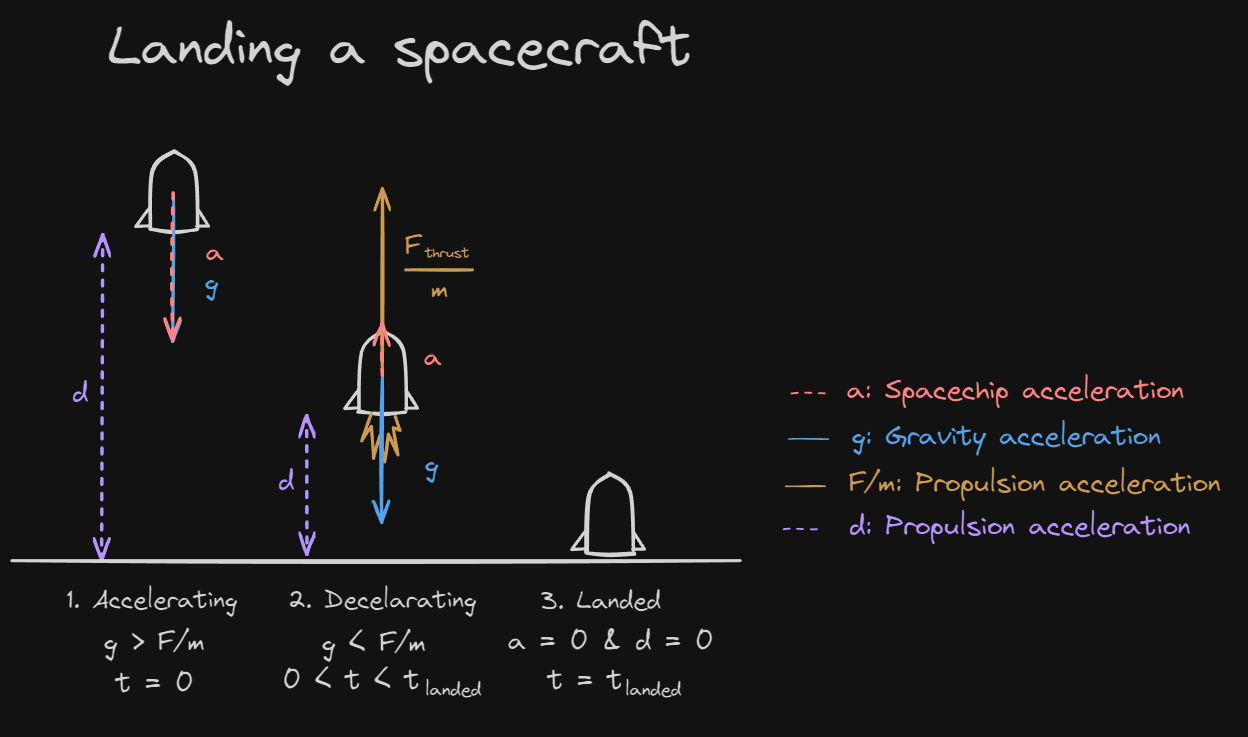

The equation governing the acceleration of the spacecraft can be written down as:
$$\frac{F_{thrust}}{m} − g - a = 0$$

#### Goal

From an initial state with height $d$, veloxity $v$, and acceleration $a$ we would like to end up at ground level ($d = 0$) with no velocity ($v = 0$). This will be concidered a succesful landing.

The initial conditions are given by:

$$\{ d,v,a \} = \{ 0,0,g \} \; \textup{at} \; t = 0 \; \textup{s}$$

#### Boundary conditions / constraints

1. The maximum thrust is limited and cannot be negative: $0 \leq  F_{thrust} \leq F_{max}$ (limited via tanh)
2. At no point can $d < 0$

#### Loss


**Physics:**

$$L_{phys}(d)=\frac1{N_{\Omega}}\sum_{j=1}^{N_{\Omega}}\|\mathcal{F}(t_j;d)\|_2^2\mathrm{~for~}t_j\in\Omega.$$

* $L_{phys}(d)$: This is the physics loss, which quantifies the deviation of the neural network predictions from the governing physics equations.
* $\frac1{N_{\Omega}}\sum_{j=1}^{N_{\Omega}}$: This part calculates the average over a set of samples within the domain $\Omega$. $N_{\Omega}$ represents the number of samples taken within the domain.
* $\| \mathcal{F}(t_j; d) \|_2^2$: This term measures the squared Euclidean norm of the residual function $\mathcal{F}(t_j; d) $ at each sample point $t_j$ within the domain. Here, $\mathcal{F}(t_j; d)$ represents the residual of the governing physics equation at time $t_j$ given by the distance $d$.

The residual of the governing physics equation is given by:
$$\mathcal{F}= \frac{F_{thrust}}{m} − g - \ddot{d}$$

**Constraints:**

The constraints are given by the following formuls:
$$L_{con}(d)=\frac1{N_{\partial\Omega}}\sum_{j=1}^{N_{\partial\Omega}}\|\hat{u}(t_j;d)-BC(t_j, d)\|_2^2$$

Where the boandary condition is:

$$BC(t_j, d) = \left\{\begin{matrix}
\hat{u}(t_j;d) \: \textup{for} \:  d \: \geq 0
\\ 
0 \: \textup{for} \: d < 0
\end{matrix}\right.$$

**Goal:**
The goal loss can be simply stated as:
$$L_{goal}(d) = d^2 \; \textup{at} \; t = t_{max}$$

**Weights:**
$$\{ w_{phys},w_{con},w_{goal} \} = \{ 1,1,1 \}$$

For optimisation:

$$d\to d^*=\operatorname*{argmin}_{d}\{w_{\mathrm{phys}}L_{\mathrm{phys}}(d)+w_{\mathrm{con}}L_{\mathrm{con}}(d)+w_{\mathrm{goal}}L_{\mathrm{goal}}(d)\}$$



